In [ ]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from google.colab import drive

import matplotlib.pyplot as plt
import seaborn as sns


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
# 파일 호출
drive.mount('/content/drive')
data_path: str = "/content/drive/MyDrive/data/data"
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)
df

Mounted at /content/drive


,ID,target,_type
0,2023-01-01 00:00:00,2.0,train
1,2023-01-01 01:00:00,1.0,train
2,2023-01-01 02:00:00,1.0,train
3,2023-01-01 03:00:00,1.0,train
4,2023-01-01 04:00:00,2.0,train
...,...,...,...
2787,2024-04-26 03:00:00,NaN,test
2788,2024-04-26 04:00:00,NaN,test
2789,2024-04-26 05:00:00,NaN,test
2790,2024-04-26 06:00:00,NaN,test


In [ ]:
# HOURLY_ 로 시작하는 .csv 파일 이름을 file_names 에 할딩
file_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_") and f.endswith(".csv")
]

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")

# df를 CSV 파일로 저장
output_path = "/content/drive/MyDrive/data/data/merged_data.csv"  # 저장할 파일 경로 설정
df.to_csv(output_path, index=False)  # index=False 옵션으로 인덱스 열은 저장하지 않음

print(f"CSV 파일이 성공적으로 저장되었습니다: {output_path}")

df.T

100%|██████████| 107/107 [00:03<00:00, 31.07it/s]


CSV 파일이 성공적으로 저장되었습니다: /content/drive/MyDrive/data/data/merged_data.csv


,0,1,2,3,4,5,6,7,8,9,...,11542,11543,11544,11545,11546,11547,11548,11549,11550,11551
ID,2023-01-01 00:00:00,2023-01-01 01:00:00,2023-01-01 02:00:00,2023-01-01 03:00:00,2023-01-01 04:00:00,2023-01-01 05:00:00,2023-01-01 06:00:00,2023-01-01 07:00:00,2023-01-01 08:00:00,2023-01-01 09:00:00,...,2024-04-25 22:00:00,2024-04-25 23:00:00,2024-04-26 00:00:00,2024-04-26 01:00:00,2024-04-26 02:00:00,2024-04-26 03:00:00,2024-04-26 04:00:00,2024-04-26 05:00:00,2024-04-26 06:00:00,2024-04-26 07:00:00
target,2.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
_type,train,train,train,train,train,train,train,train,train,train,...,test,test,test,test,test,test,test,test,test,test
hourly_market-data_funding-rates_deribit_funding_rates,0.000571,0.00057,0.000566,0.000557,0.000536,0.000309,0.000185,0.000088,-0.00004,-0.00004,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hourly_market-data_liquidations_binance_btc_busd_long_liquidations,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hourly_network-data_addresses-count_addresses_count_active,67987,30593,33897,32717,45176,35894,47985,31927,38999,28186,...,46321,0,53221,50719,38992,29250,56580,51858,36270,31851
hourly_network-data_addresses-count_addresses_count_sender,37307,12342,17737,11421,17320,23611,30536,18821,23092,12534,...,25768,0,27264,29569,22700,18154,31320,34083,26186,18649
hourly_network-data_addresses-count_addresses_count_receiver,37752,20534,19369,23799,31712,14029,21328,15648,19085,18180,...,24446,0,30913,25331,19502,13601,29096,22094,12668,16054
hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close,16536.747967,16557.136536,16548.149805,16533.632875,16524.712159,16529.408065,16541.530683,16532.20215,16519.005107,16540.824017,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# train 데이터를 기반으로 eda_df 다시 정의
# eda_df = df.loc[df["_type"] == "train"]

# 100% 결측인 열을 제거
eda_df_cleaned = df.dropna(axis=1, how='all')
eda_df_cleaned = eda_df_cleaned.reindex(sorted(eda_df_cleaned.columns), axis=1)

# eda_df_cleaned를 CSV 파일로 저장
eda_df_cleaned.to_csv('/content/drive/MyDrive/data/data/eda_df_cleaned.csv', index=False)

# 각 열의 결측값 수 계산
missing_values_cleaned = eda_df_cleaned.isnull().sum()

# 결측값이 없는 열의 개수 계산
no_missing_columns_count = (missing_values_cleaned == 0).sum()

# 결측값이 없는 열의 개수 출력
print(f"결측값이 없는 열의 개수: {no_missing_columns_count}")

# 결측값 비율을 백분율로 계산
missing_percentage_cleaned = (missing_values_cleaned / len(eda_df_cleaned)) * 100

# 결측값 수와 비율을 하나의 데이터프레임으로 정리
missing_summary = pd.DataFrame({
    'missing_values': missing_values_cleaned,
    'missing_percentage': missing_percentage_cleaned
})

# 결측값 비율을 기준으로 정렬
missing_summary_sorted = missing_summary.sort_values(by='missing_percentage', ascending=False)

# 정렬된 결측값 요약 출력
missing_summary_sorted


결측값이 없는 열의 개수: 33


,missing_values,missing_percentage
hourly_market-data_liquidations_binance_btc_busd_short_liquidations_usd,2880,24.930748
hourly_market-data_liquidations_binance_btc_busd_short_liquidations,2880,24.930748
hourly_market-data_liquidations_binance_btc_busd_long_liquidations_usd,2880,24.930748
hourly_market-data_liquidations_binance_btc_busd_long_liquidations,2880,24.930748
hourly_market-data_open-interest_binance_btc_busd_open_interest,2880,24.930748
...,...,...
hourly_network-data_addresses-count_addresses_count_sender,0,0.000000
hourly_market-data_liquidations_htx_global_btc_usd_short_liquidations,0,0.000000
hourly_market-data_liquidations_htx_global_btc_usd_long_liquidations_usd,0,0.000000
hourly_market-data_liquidations_htx_global_btc_usd_long_liquidations,0,0.000000


In [ ]:
# 20% 이상의 결측값을 가진 열을 필터링하여 제거 (단, 'target' 컬럼은 유지)
columns_to_keep = missing_summary_sorted[(missing_summary_sorted['missing_percentage'] <= 20) | (missing_summary_sorted.index == 'target')].index
eda_df_filtered = eda_df_cleaned[columns_to_keep]

# 결과를 다시 CSV 파일로 저장
eda_df_filtered.to_csv('/content/drive/MyDrive/data/data/eda_df_filtered.csv', index=False)


In [ ]:
drive.mount('/content/drive')

# CSV 파일을 데이터프레임으로 불러오기
eda_df_filtered = pd.read_csv('/content/drive/MyDrive/data/data/eda_df_filtered.csv')

# 확인용: 상위 5개 행 출력
print(eda_df_filtered.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   hourly_market-data_open-interest_gate_io_btc_usd_open_interest  \
0                                                      21461315.0   
1                                                      21464662.0   
2                                                      21481446.0   
3                                                      21534989.0   
4                                                      21534219.0   

   hourly_market-data_liquidations_bitfinex_all_symbol_short_liquidations  \
0                                                                     0.0   
1                                                                     0.0   
2                                                                     0.0   
3                                                                     0.0   
4                                                                     0

<ipython-input-40-f79ebb0fcf0a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eda_df_filtered['ID'] = pd.to_datetime(eda_df_filtered['ID'], errors='coerce')


0   2023-01-01 00:00:00
1   2023-01-01 01:00:00
2   2023-01-01 02:00:00
3   2023-01-01 03:00:00
4   2023-01-01 04:00:00
Name: ID, dtype: datetime64[ns]


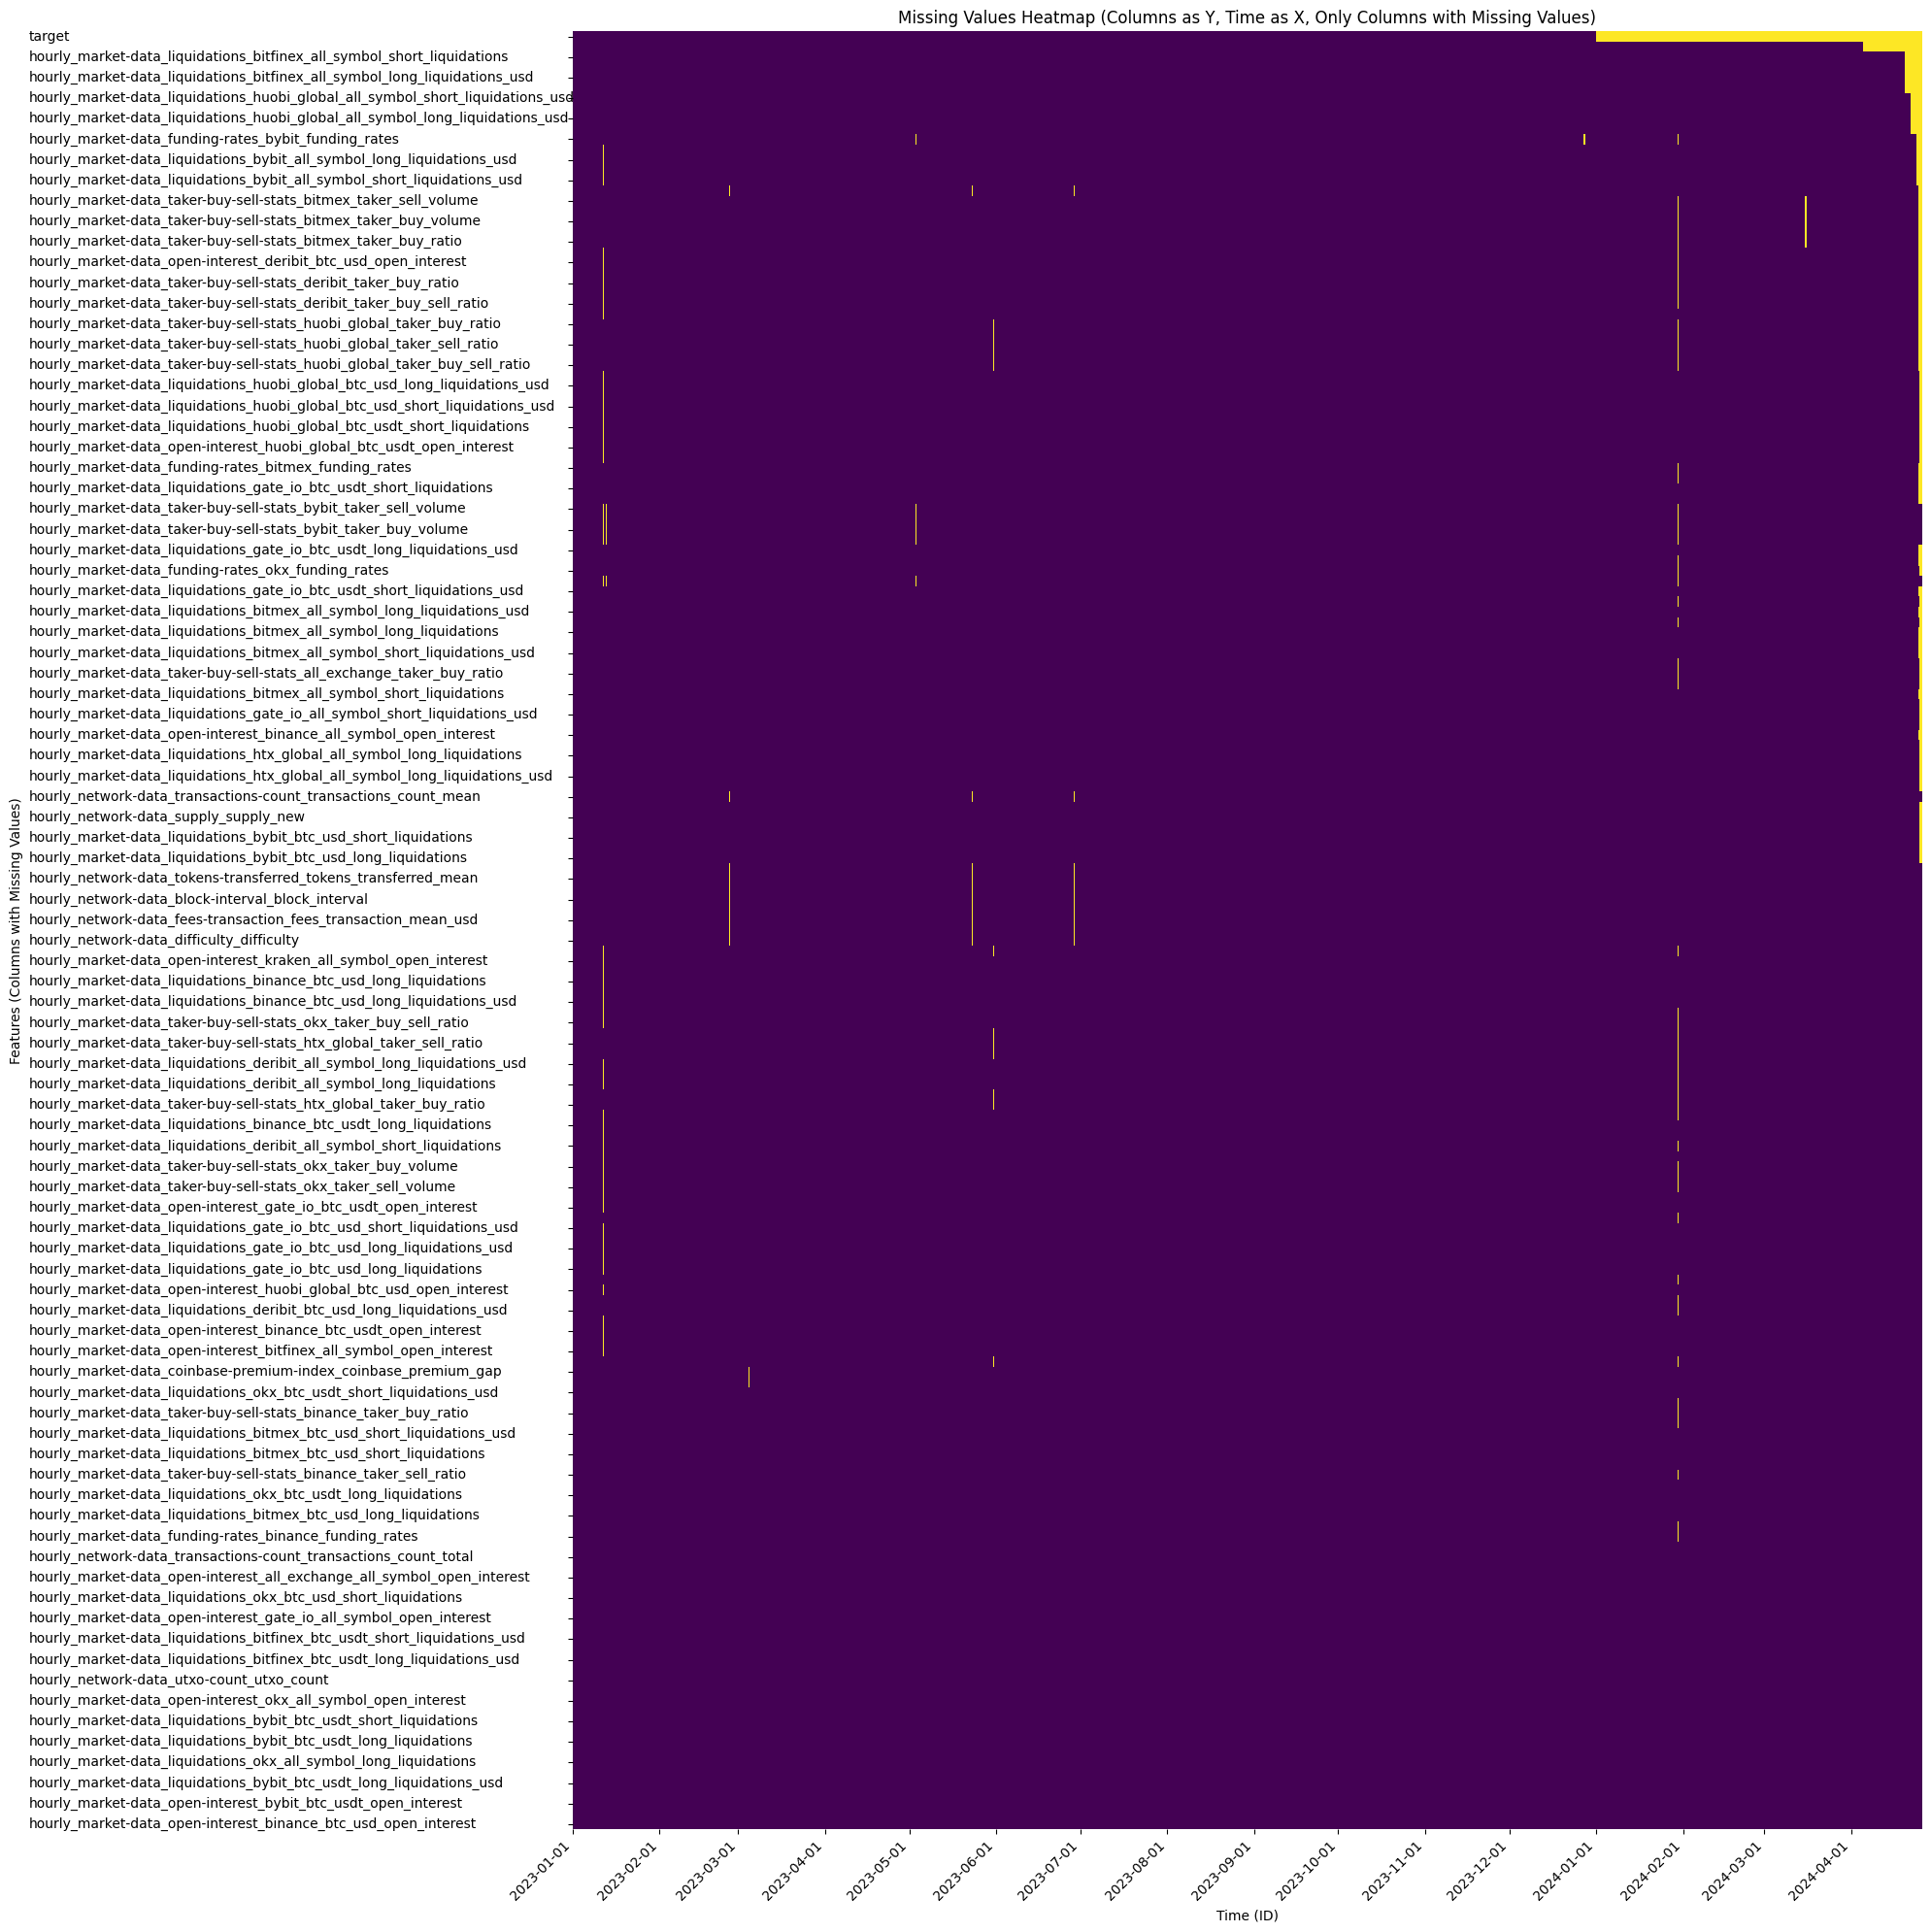

In [ ]:


# ID 열이 datetime 형식으로 변환되었는지 확인하고 변환 (경고 해결)
eda_df_filtered['ID'] = pd.to_datetime(eda_df_filtered['ID'], errors='coerce')

# ID 열이 제대로 변환되었는지 확인 (확인용 코드)
print(eda_df_filtered['ID'].head())

# 결측값이 있는 열만 필터링, ID 열은 그대로 유지
missing_columns = eda_df_filtered.columns[eda_df_filtered.isnull().sum() > 0].tolist()
missing_columns.append('ID')  # ID 열 추가

# 결측값이 있는 열들만 필터링한 데이터프레임 생성
eda_df_filtered_missing_only = eda_df_filtered[missing_columns]

# ID를 x축에 놓고, 열을 y축에 놓기 위해 데이터프레임을 전치(transpose)
eda_df_transposed_missing_only = eda_df_filtered_missing_only.set_index('ID').T

# 히트맵 시각화
plt.figure(figsize=(20, 20))  # 원하는 크기로 조정

# 결측값 히트맵: 열을 y축에, 시간을 x축에 표시
sns.heatmap(eda_df_transposed_missing_only.isnull(), cbar=False, cmap='viridis')

# x축 눈금을 매월 1일로 맞춤
monthly_ticks = eda_df_filtered.loc[(eda_df_filtered['ID'].dt.day == 1) & (eda_df_filtered['ID'].dt.hour == 0), 'ID']
plt.xticks(ticks=eda_df_filtered.index[eda_df_filtered['ID'].isin(monthly_ticks)],
           labels=monthly_ticks.dt.strftime('%Y-%m-%d'), rotation=45, ha="right")

# y축 레이블을 왼쪽으로 정렬
plt.yticks(rotation=0, ha="left")
plt.gca().yaxis.set_tick_params(pad=400)  # y축 레이블과 히트맵 사이의 간격 조정

plt.title('Missing Values Heatmap (Columns as Y, Time as X, Only Columns with Missing Values)')
plt.ylabel('Features (Columns with Missing Values)')
plt.xlabel('Time (ID)')
plt.tight_layout()
plt.show()

In [ ]:
# 기본적인 통계 요약
print(eda_df_filtered.describe())

       hourly_market-data_open-interest_gate_io_btc_usd_open_interest  \
count                                                    1.104200e+04   
mean                                                     2.434041e+07   
min                                                      4.536560e+06   
25%                                                      7.062962e+06   
50%                                                      8.204863e+06   
75%                                                      4.347886e+07   
max                                                      8.329108e+07   
std                                                      2.257919e+07   

       hourly_market-data_liquidations_bitfinex_all_symbol_short_liquidations  \
count                                                            11402.000000   
mean                                                                 0.414318   
min                                                                  0.000000   
25%               

In [ ]:
# 타겟과의 상관관계 분석을 위해 필요하지 않은 컬럼 제외
# 예: _type 컬럼 (train/test 구분), ID 컬럼
columns_to_exclude = ['ID', '_type']  # 필요에 따라 추가할 수 있음
features_for_corr = eda_df_filtered.drop(columns=columns_to_exclude)

# 상관관계 분석 수행
corr_matrix = features_for_corr.corr()

# 타겟과의 상관관계 출력
if 'target' in corr_matrix.columns:
    print(corr_matrix['target'].sort_values(ascending=False))
else:
    print("타겟과의 상관관계를 분석할 수 없습니다. 'target' 컬럼이 존재하는지 확인하세요.")

target                                                                       1.000000
hourly_market-data_liquidations_binance_all_symbol_long_liquidations_usd     0.055130
hourly_market-data_liquidations_binance_all_symbol_long_liquidations         0.055063
hourly_market-data_liquidations_binance_btc_usdt_long_liquidations           0.054655
hourly_market-data_liquidations_binance_btc_usdt_long_liquidations_usd       0.054421
                                                                               ...   
hourly_market-data_taker-buy-sell-stats_bitmex_taker_buy_ratio              -0.029445
hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_ratio        -0.049467
hourly_market-data_taker-buy-sell-stats_binance_taker_buy_ratio             -0.049724
hourly_market-data_taker-buy-sell-stats_binance_taker_buy_sell_ratio        -0.051100
hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_sell_ratio   -0.051326
Name: target, Length: 206, dtype: float64


In [ ]:
import lightgbm as lgb

# 데이터 준비 (특징과 타겟 분리)
X = eda_df_filtered.drop(columns=['target','_type','ID'])  # 타겟 변수를 제외한 특징들
y = eda_df_filtered['target']  # 타겟 변수

# LightGBM 모델 훈련
model = lgb.LGBMClassifier()
model.fit(X, y)

# 특징 중요도 시각화
import matplotlib.pyplot as plt
import seaborn as sns

feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
})

# 중요도 순으로 정렬
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Feature Importance')
plt.show()

ValueError: Input contains NaN.